In [1]:
%load_ext autoreload
%autoreload 2

import requests
import torch
from torch.utils.data import DataLoader
import random
import torch.nn as nn 
from torch import optim
# from sklearn.decomposition import TruncatedSVD as svds
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from torch.nn.utils.rnn import pad_sequence
from spice import SpiceEmbeddingModel
from gru import GRUEncoder, GRUDecoder
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import re
import pickle
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from tpdn import TPDNEncoder
import spice

In [2]:

URL = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
FILE_PATH = "shakespeare.txt"
EMB_DIM = 64
WINDOW = 5


try:
    with open(FILE_PATH, 'r', encoding='utf-8') as f:
        text = f.read()
except FileNotFoundError:
    response = requests.get(URL)
    text = response.text
    with open(FILE_PATH, 'w', encoding='utf-8') as f:
        f.write(text)


spice_model = SpiceEmbeddingModel(emb_dim=50, window_size=3)



spice_model.load_model()
dataset = spice_model.get_dataset(text)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/home/baptiste/Documents/cours/projet_3A/TPDN_roles_like transformers/spice.py:127: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor([self.embeddings[self.word2idx[word]] for word in sentence.split() if word in self.word2idx], dtype=torch.float32)


In [3]:


input_size = 50       # dim des fillers 
role_dim = 20         # dim  des vecteurs de rôle
hidden_size = 128     # dim de la représentation latente
lr = 0.001
num_layers = 3
num_epochs = 20
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


spice_model = SpiceEmbeddingModel(emb_dim=input_size, window_size=3)
try : 
    spice_model.load_model()
except : 
    pass

dataset = spice_model.get_dataset(text, role_dim=role_dim)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=spice.collate_fn_fillers_roles)



Epoch 1/20, Loss: 0.021912576699502428
Epoch 2/20, Loss: 0.014352367032022978
Epoch 3/20, Loss: 0.0138365620567294
Epoch 4/20, Loss: 0.01356506233886731
Epoch 5/20, Loss: 0.013370959791989828
Epoch 6/20, Loss: 0.013231246009871194
Epoch 7/20, Loss: 0.013124792521755973
Epoch 8/20, Loss: 0.013031958597077226
Epoch 9/20, Loss: 0.012988355883862823
Epoch 10/20, Loss: 0.012928922994019971
Epoch 11/20, Loss: 0.012916890433354472
Epoch 12/20, Loss: 0.012897598509549756
Epoch 13/20, Loss: 0.012880791079210625
Epoch 14/20, Loss: 0.012877030081157996
Epoch 15/20, Loss: 0.012886205055772072
Epoch 16/20, Loss: 0.012883448026100681
Epoch 17/20, Loss: 0.012877034838311374
Epoch 18/20, Loss: 0.012887936088108372
Epoch 19/20, Loss: 0.012867927739121527
Epoch 20/20, Loss: 0.012871344560566782


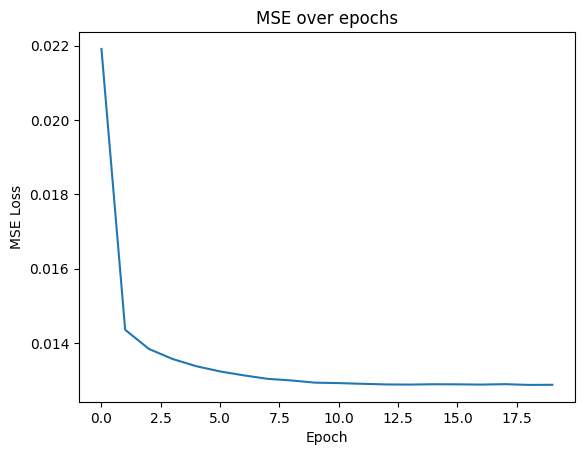

In [4]:



encoder_rnn = torch.load("encoder.pth", weights_only=False).to(device)

tpdn_encoder = TPDNEncoder(input_size, role_dim, hidden_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(tpdn_encoder.parameters()),lr=lr)
encoder_rnn.eval()
tpdn_encoder.train()
losses = []
for epoch in range(num_epochs):
    total_loss = 0.0
    for fillers, roles, lengths in dataloader:
        fillers = fillers.to(device)  # (batch, seq_len, input_size)
        roles = roles.to(device)        # (batch, seq_len, role_dim)
        lengths = lengths.to(device)    # (batch,)
        optimizer.zero_grad()

        encoded_tpdn = tpdn_encoder(fillers, roles, lengths)  # (batch, hidden_size)
        # reconstructed = decoder(encoded, lengths)         # (batch, max_seq_len, input_size)
        with torch.no_grad():
            encoded_rnn, _ = encoder_rnn(fillers, lengths)
        
        loss = criterion(encoded_tpdn, encoded_rnn)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")


torch.save(tpdn_encoder, "tpdn_encoder.pth")



plt.plot(losses)
plt.title("MSE over epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()


In [6]:


def decode_sequence(spice_model, sequence):
    """decode les embeddings en mots"""
    decoded_words = []
    for embedding in sequence.cpu():
        if embedding.sum() != 0:  # ignorer le padding pour récupérer la taille de la vrai séquence
            decoded_words.append(spice_model.decode_embedding(embedding.detach().numpy(), top_n=1)[0])
    return " ".join(decoded_words)

fillers, roles, lengths = next(iter(dataloader))  
idx = random.randint(0, fillers.size(0) - 1)  #  phrase au hasard
input_seq = fillers[idx].unsqueeze(0).to(device)  # le tenseur avec du padding
roles = roles[idx].unsqueeze(0).to(device)
mask = (input_seq != 0).any(dim=2)  # vérifie si chaque ligne contient des valeurs non nulles
tensor_clean = input_seq[:, mask[0], :] # enlève les vecteurs nuls du padding
length = torch.tensor([tensor_clean.shape[1]]).to(device)  # récupère la longueur originale sans le padding

decoder = torch.load("decoder.pth", weights_only=False)
tpdn_encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded = tpdn_encoder(input_seq, roles, length)
    reconstructed_seq = decoder(encoded, length)


original_text = decode_sequence(spice_model, input_seq.squeeze(0))
reconstructed_text = decode_sequence(spice_model, reconstructed_seq.squeeze(0))


print(f"originale**: {original_text}")
print(f"reconstruite**: {reconstructed_text}")


originale**: sir paris i will make a desperate tender
reconstruite**: madam coriolanus to will look a captains nought
